### And welcome to Week 4, Day 3 - more LangGraph..

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper
# from google.colab import userdata
# Set your OpenAI key

os.environ["SERPER_API_KEY"] = os.getenv('SERPER_API_KEY')

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

"Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and ... The capital of France has been Paris since its liberation in 1944. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... What Is the Capital of France? Paris. The very name brings to mind tree-lined boulevards, grand monuments, sidewalk cafes, and so much more. Paris

### Now here is a LangChain wrapper class for converting functions into Tools

In [4]:
# Out of the box Tool from LangChain
from langchain.agents import Tool

tool_search =Tool(
        name="Serper_Search",
        func=serper.run,
        description="Useful search tool for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [5]:
tool_search.invoke("What is the capital of France?")

"Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most ... The capital of France has been Paris since its liberation in 1944. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Dive into the charm of Paris, the capital of France! Explore its rich history, iconic attractions, and delectable cuisine in our guide. Paris became capital of 

### And now let's write a tool ourselves

We'll pick a familiar one

In [6]:
# Custom Tool by using Pushover
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [7]:
tool_pushover = Tool(
        name="Pushover_Notification",
        func=push,
        description="useful notification tool for when you want to send a Pushover notification"
    )

tool_pushover.invoke("Hello, me")

### Back to the Graph from yesterday

One small change - using **TypedDict** instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [8]:
tools = [tool_search, tool_pushover]

In [9]:
tools

[Tool(name='Serper_Search', description='Useful search tool for when you need more information from an online search', func=<bound method GoogleSerperAPIWrapper.run of GoogleSerperAPIWrapper(k=10, gl='us', hl='en', type='search', result_key_for_type={'news': 'news', 'places': 'places', 'images': 'images', 'search': 'organic'}, tbs=None, serper_api_key='b3cf59ac4419d9a8d178413be78c9aefd8d7c6f6', aiosession=None)>),
 Tool(name='Pushover_Notification', description='useful notification tool for when you want to send a Pushover notification', func=<function push at 0xff327f2bfd80>)]

In [10]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [11]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

## 1. Provide the tools to OpenAI in json when we make the call

```python
llm_with_tools = llm.bind_tools(tools)
```

**binds the tools to the ChatOpenAI model**, allowing the model to:

1. **Understand which tools are available**, by encoding their function schema in **JSON-compatible format** via OpenAI's function-calling spec.
2. **Automatically trigger tool calls**, based on the LLM's understanding of the user's request.
3. **Return a response with `tool_calls`**, which your code then detects and handles.



In [12]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [13]:
# Step 3: Create a Node

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

## 2. Handle the results back

```python
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
```

### 🔄 **Flow logic after the `chatbot` node runs**:

1. ✅ **`chatbot` node runs**
   It produces an output, possibly containing a `tool_calls` field.

2. ✅ **`tools_condition(state)` runs**
   This function examines the output state to check if:

   ```python
   state["messages"][-1].tool_calls  # ← LangChain/LLM tool call detection
   ```

3. ✅ **If `tool_calls` are present**:

   * The graph routes to the `"tools"` node (via `add_conditional_edges`).
   * Then **after tool execution**, the graph **returns to the `chatbot` node** with the tool results.
   * This loop continues until **no more `tool_calls`**.

4. ✅ **If no `tool_calls` remain**:

   * The graph reaches the `"END"` node — workflow is completed.

---

### 🔁 Visual Summary:

```
START
  ↓
chatbot
  ↓
┌────────────────────────────┐
│ if tool_calls              │
│   ↓                        │
│  tools ─────────┐          │
│    ↓            │          │
│  chatbot <──────┘ (loop)   │
└────────────────────────────┘
  ↓
END  (when no more tool_calls)
```


In [14]:
# Step 4: Create Edges

graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

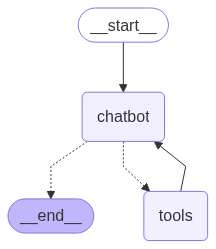

In [15]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [16]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a **single** iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [17]:
# Memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Compile with checkpoint ...
graph = graph_builder.compile(**checkpointer=memory**)

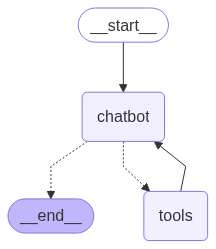

In [18]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [20]:
state = graph.get_state(config)
print(f"🔢 Number of states: {len(state)}\n")
state[0]

🔢 Number of states: 8



{}

In [21]:
# Most recent first
# Get the full state history as a list
history = list(graph.get_state_history(config))
# Print the length (i.e., how many steps have been recorded)
print(f"🔢 Number of states in history: {len(history)}\n")

# Optionally: print the most recent state (index 0)
# print("📌 Most recent state snapshot:", history[0])

🔢 Number of states in history: 0



### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [22]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

## Compile with checkpoint ...

graph = graph_builder.compile(**checkpointer=sql_memory**)

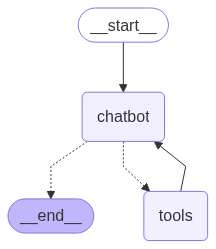

In [23]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [24]:
config = {"configurable": {"thread_id": "3"}}
# config = {"configurable": {"thread_id": "2"}}
# config = {"configurable": {"thread_id": "4"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [25]:
state = graph.get_state(config)
print(f"🔢 Number of states: {len(state)}\n")
state[0]

🔢 Number of states: 8



{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='d6144090-9963-438c-b21b-3fb4f06edbc0'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 90, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BInN7JUnEYNTQqokCF3eihp5oKP0V', 'finish_reason': 'stop', 'logprobs': None}, id='run-4b488710-73ac-435e-a944-913a0c812d08-0', usage_metadata={'input_tokens': 90, 'output_tokens': 11, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content="what's my name", additional_kw

In [26]:
# Convert the state history to a list first (graph.get_state_history is a generator)
state_history = list(graph.get_state_history(config))

# Print the number of states in history
print("🔢 Get State Length:", len(state_history), "\n")

# Print the most recent state (index 0)
print("📌 Most Recent State Snapshot:\n", state_history[0])


🔢 Get State Length: 57 

📌 Most Recent State Snapshot:
 StateSnapshot(values={'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='d6144090-9963-438c-b21b-3fb4f06edbc0'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 90, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BInN7JUnEYNTQqokCF3eihp5oKP0V', 'finish_reason': 'stop', 'logprobs': None}, id='run-4b488710-73ac-435e-a944-913a0c812d08-0', usage_metadata={'input_tokens': 90, 'output_tokens': 11, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0